In [1]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time 
import pickle
import warnings

from utils import *

from sensor_params import *

from models.training import *

from models.single_step.unet1D_regressor import *
from models.single_step.unet1D_regressor import get_model as get_unet1D

from models.single_step.unet1D_DIL_regressor import *
from models.single_step.unet1D_DIL_regressor import get_model as get_DIL_unet1D

from models.single_step.LSTMVanilla import *
from models.single_step.LSTMVanilla import get_model as get_LSTM

from models.single_step.unet1D_LSTM_regressor import *
from models.single_step.unet1D_LSTM_regressor import get_model as get_unet1DLSTM

from models.single_step.unet1D_nonCompres_regressor import *
from models.single_step.unet1D_nonCompres_regressor import get_model as get_unet1D_nonCompres

from evaluation.single_step.evaluation import model_evaluation

# Dataset path 
DATABASE_PATH = r"C:\Users\aralmeida\OneDrive - Universidad de Las Palmas de Gran Canaria\Doctorado\Bases de datos\WARIFA\Mikael T1DM"

filename = "MIKAEL_data.json"

parent_directory = r"C:\Users\aralmeida\Downloads"
experiments_folder = r"\T1DM_pred_experiments" 

In [2]:
# Load data from the json file. If executed, comment the line and load the data from the pickle file
# data , basal_data_dict, blood_pressure_dict, bolus_data_dict, exercise_data_dict, carbohydrates_data_dict, pump_events_data_dict, sgv_data_dict, sleep_data_dict, smgb_data_dict, steps_data_dict, weight_dict  = extract_Mikael_data(DATABASE_PATH, filename, ONLY_CGM = True)
with open(DATABASE_PATH+'\CGM.pk1', 'rb') as f:
    sgv_data_dict = pickle.load(f)
os.chdir(parent_directory)

In [3]:
N = 144
tau = 1
PH = 5
pred_steps = 1
normalization = 'min-max'
undersampling = True
name = '1DUNET-non-compres_himar-rep'

In [4]:
X, Y, X_times, Y_times = get_CGM_X_Y(sgv_data_dict, sensor_Mikael, N, tau, PH, experiments_folder, plot=False, verbose = 0)

Number of blocks is 335



In [5]:
# Min-max normalization
if normalization == 'min-max':
    X_norm = (X - np.min(X))/(np.max(X) - np.min(X))
    Y_norm = (Y - np.min(X))/(np.max(X) - np.min(X))
elif normalization == None: 
    X_norm = X
    Y_norm = Y

In [6]:
(180 - np.min(X))/(np.max(X) - np.min(X))

0.4329896907216495

In [7]:
# Simple partition (imitating Himar work for comparison): X_train until 30/05/2021 and X_test from 31/05/2021
# Instances that include two days are removed
X_train = X_norm[np.where(X_times[:,N-1] <= pd.to_datetime('2021-05-31 00:00:00'))[0]]
Y_train = Y_norm[np.where((Y_times[:,0] < pd.to_datetime('2021-05-30 23:59:59')))[0]]
X_test = X_norm[np.where((X_times[:,N-1] > pd.to_datetime('2021-06-01 00:00:00')))[0]]
Y_test = Y_norm[np.where((Y_times[:,0] > pd.to_datetime('2021-06-01 00:00:00')))[0]] # Left non-normalized to compute the metrics

print("X_train shape: ",str(X_train.shape))
print("Y_train shape: ",str(Y_train.shape))
print("X_test shape: ",str(X_test.shape))
print("Y_test shape: ",str(Y_test.shape))

X_train shape:  (114969, 144)
Y_train shape:  (114969, 1)
X_test shape:  (43372, 144)
Y_test shape:  (43372, 1)


In [9]:
if undersampling == True:
    X_train, Y_train  = undersample_normal_range_outputs(X, X_train, Y_train, normalization = normalization, undersampling_factor = 2)
else : 
    pass

YIELKA
0.32474226
0.4329896907216495
0.14948453608247422
Number of normal range points to train before undersampling:  93230
Number of hyperglycemia points to train before undersampling:  16428
Number of hypoglycemia points to train before undersampling:  5311
Percentage of samples in the normal range:  81.09
Percentage of samples in the hyperglycamia range:  14.29
Percentage of samples in the hypoglycamia range:  4.62


In [10]:
X_train.shape[0]

54595

In [11]:
# Parameters for training
# Best parameters for the model N 48
lr = 0.0001
batch_size = 2
epochs = 10

kernel_size = 3

In [12]:
lr = 0.0001
batch_size = 512
epochs = 2

In [13]:
# Get model instance
model =  get_unet1D(N=N,
                input_features = NUMBER_OF_INPUT_SIGNALS,
                tau=tau,
                kernel_size=kernel_size)

# model =  get_unet1D_nonCompres(N=N,
#                 input_features = NUMBER_OF_INPUT_SIGNALS,
#                 tau=tau,
#                 kernel_size=kernel_size)

# model =  get_DIL_unet1D(N=N,
#                 input_features = NUMBER_OF_INPUT_SIGNALS,
#                 tau=tau,
#                 kernel_size=kernel_size,
#                 dilation_rate=1)

# model =  get_LSTM(N=int(N),
#                 input_features = NUMBER_OF_INPUT_SIGNALS)

# model =  get_unet1DLSTM(N=N,
#                 input_features = NUMBER_OF_INPUT_SIGNALS)

Epoch 1/2
107/107 [==============================] - 28s 241ms/step - loss: 0.0624 - root_mean_squared_error: 0.2499
Epoch 2/2
107/107 [==============================] - 18s 173ms/step - loss: 0.0230 - root_mean_squared_error: 0.1517
	End of the training. Model saved in C:\Users\aralmeida\Downloads\T1DM_pred_experiments\N144_step1_PH1\training


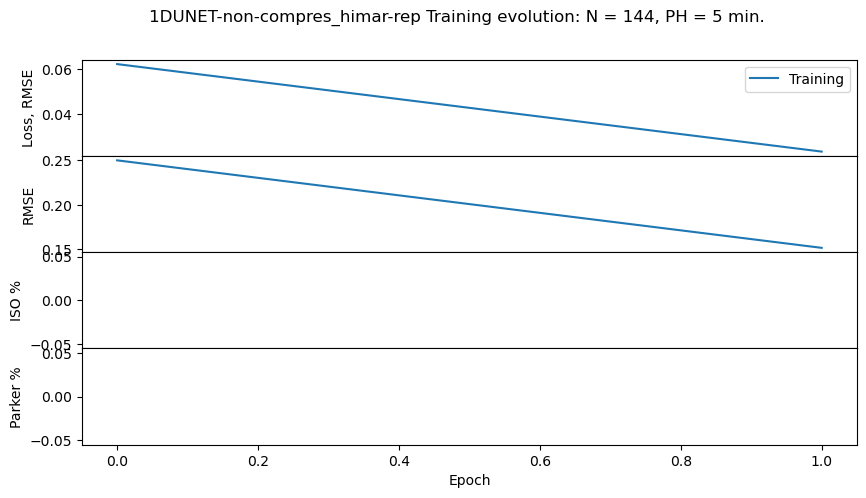

In [14]:
train_model(sensor_Mikael,
            model,
            X = X_train,
            Y = Y_train,
            N = N,
            predicted_points = 1,
            epochs = epochs,
            batch_size = batch_size,
            lr = lr,
            verbose = 1, 
            fold = name)

1356/1356 [==============================] - 4s 3ms/step
1DUNET-non-compres_himar-rep Test RMSE:   51.155815
1DUNET-non-compres_himar-rep Test MAE:   41.177013
1DUNET-non-compres_himar-rep Test MAPE:   40.07100462913513


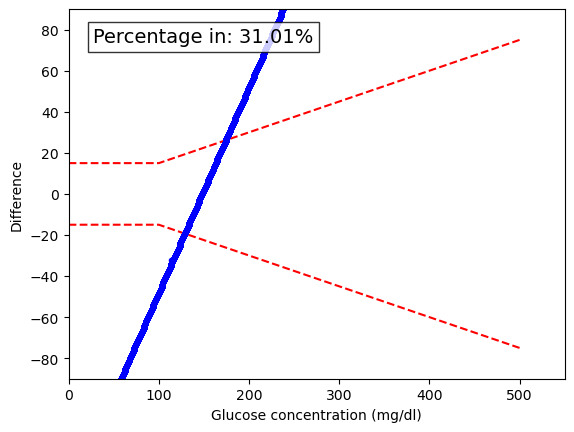

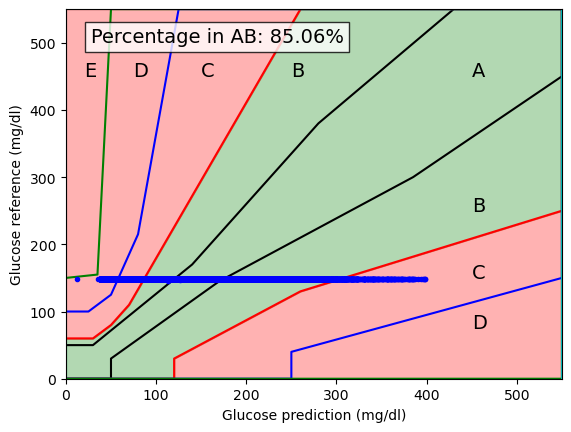

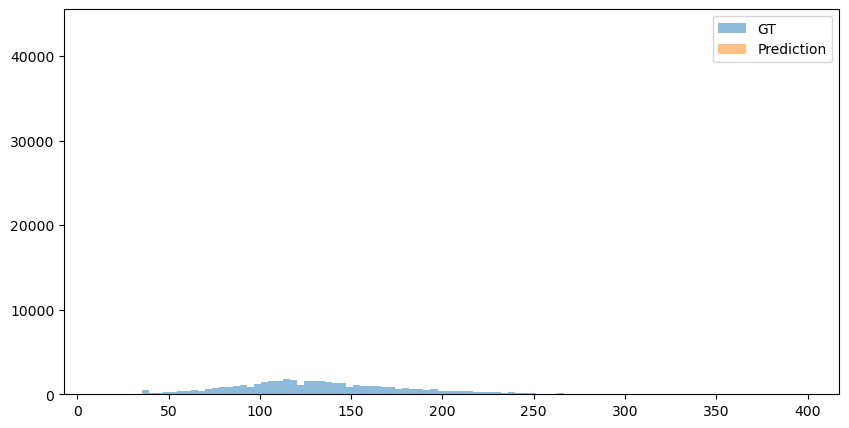

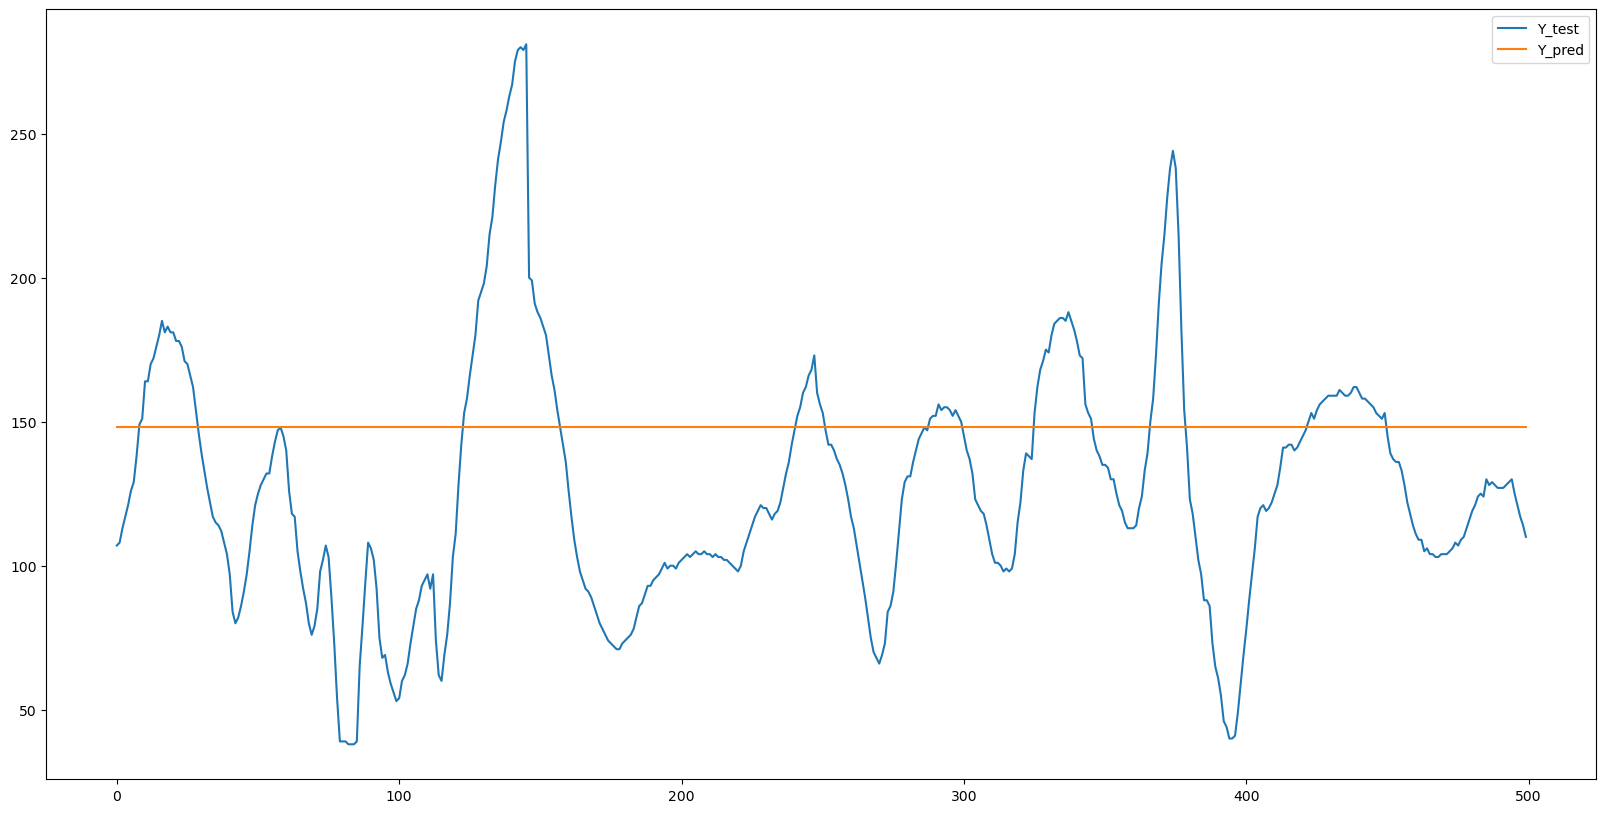

In [15]:
model_evaluation(N, PH, name, normalization, X_test, Y_test, X)